# C-HMC Projection vs HUG Bounce

In [2]:
import numpy as np
from numpy import zeros, eye, array, exp, linspace, vstack
from numpy.random import randn, default_rng, randint
from numpy.linalg import norm, solve

from scipy.stats import multivariate_normal as MVN
from scipy.optimize import fsolve, root

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

from Manifolds.GeneralizedEllipse import GeneralizedEllipse
from utils import prep_contour, line_perp_v_through_point

In [3]:
μ = zeros(2)
Σ = array([[5.0, 0.0], [0.0, 1.0]])
π = MVN(μ, Σ)
f = π.logpdf
grad_f = lambda x: - solve(Σ, x - μ)
#z0 = -2.9513586307684885
z0 = -8.0

In [4]:
ellipse = GeneralizedEllipse(μ, Σ, exp(z0))

In [5]:
manifold = prep_contour([-8, 8], [-8, 8], 0.01, f)

In [6]:
find_point_closest_to = lambda point, f=f, z0=z0:  fsolve(lambda x: array([f(x) - z0, 0]), point)

In [7]:
def line_between_points(point1, point2):
    """Return x and y values to plot a line between two points."""
    # Find x_values
    x_min = min(point1[0], point2[0])
    x_max = max(point1[1], point2[1])
    x_values = linspace(x_min, x_max)
    # Find y_values
    slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
    y_values = x_values * slope + point1[1]
    return x_values, y_values

In [12]:
# Points and Velocities for Zappa RWM
init_point = array([-1, 1.6])#array([-1.25, 0.75])
x0 = find_point_closest_to(init_point)
v0 = sample_along_tangent(x0, v=1.5, σ=5.0)
λ  = project(x0, v0, ellipse.Q(x0), ellipse.q)[0]
x1 = (x0 + v0) + ellipse.Q(x0) @ λ

# Point for HUG
x_mid = x0 + v0
g_mid = grad_f(x_mid) / norm(grad_f(x_mid))
v1 = v0 - 2*g_mid * (g_mid @ v0)
x1_hug = x_mid + v1

# Point for HUG but using the initial Jacobian
x_mid = x0 + v0
g0 = grad_f(x0) / norm(grad_f(x0))
v1_new = v0 - 2*g0 * (g0 @ v0)
x1_hug_new = x_mid + v1_new

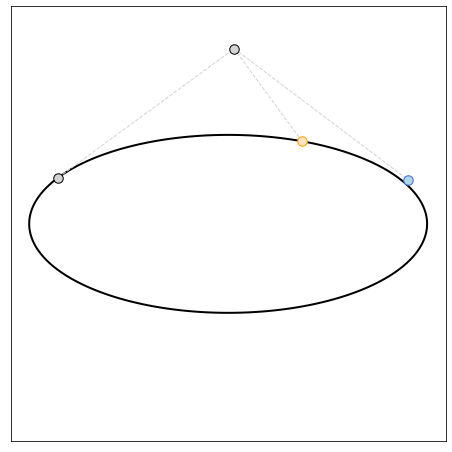

In [13]:
MANIFOLD_LW = 2.0
YMIN = -8#1.#0.0
YMAX = 8 #2.5#2.0
XMIN = -8#-1.3#-1.8
XMAX = 8#1.8#1.8
SPOINTS = 90

fig, ax = plt.subplots(figsize=(8,8))
ax.contour(*manifold, levels=[z0], linewidths=MANIFOLD_LW, colors=['black'], linestyles='solid')
# Points in Common
ax.scatter(*x0, color='lightgray', zorder=10, edgecolor='k', s=SPOINTS)
ax.scatter(*(x0+v0), color='lightgray', zorder=10, edgecolor='k', s=SPOINTS)
# # Point for Zappa RWM
ax.scatter(*x1, color='bisque', zorder=10, edgecolor='orange', s=SPOINTS)
# # Point for HUG
ax.scatter(*x1_hug, color='lightblue', zorder=10, edgecolor='royalblue', s=SPOINTS)
# # Lines
ax.plot(*connectpoints([x_mid[0], x1[0]], [x_mid[1], x1[1]], 0, 1), color='lightgrey', ls='--', lw=1.0)
ax.plot(*connectpoints([x_mid[0], x1_hug[0]], [x_mid[1], x1_hug[1]], 0, 1), color='lightgrey', ls='--', lw=1.0)
ax.plot(*connectpoints([x0[0], x_mid[0]], [x0[1], x_mid[1]], 0, 1), color='lightgrey', ls='--', lw=1.0)
#sns.kdeplot(x=velocities_zappa_updated[:, 0], y=velocities_zappa_updated[:, 1], ax=ax)
#sns.kdeplot(x=projections_zappa[:, 0], y=projections_zappa[:, 1], ax=ax)
ax.set_ylim([YMIN, YMAX])
ax.set_xlim([XMIN, XMAX])
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
plt.show()

In [9]:
def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    return [x1, x2], [y1, y2]

In [10]:
def sample_along_tangent(x, σ=1.0, seed=1234, v=1.0, use_abs=True, ellipse=ellipse):
    Qx = ellipse.Q(x)
    tx_basis = ellipse.tangent_basis(Qx)
    rng = default_rng(seed)
    #v_sample = array([v]) #σ*rng.normal(size=ellipse.get_dimension())
    if use_abs:
        v_sample = abs(σ * rng.normal(size=ellipse.get_dimension()))
    else: 
        v_sample = σ * rng.normal(size=ellipse.get_dimension())
    return tx_basis @ v_sample 

In [11]:
def project(x, v, Q, q, tol=None, a_guess=1, maxiter=50):
    """Finds a such that q(x + v + a*Q) = 0"""
    opt_output = root(lambda a: q(x + v + Q @ a), np.array([a_guess]), tol=tol, options={'maxfev':maxiter})
    return (opt_output.x, opt_output.success) # output flag for accept/reject

# I could plot the density of proposals for both and show they are somewhat similar?

In [14]:
def zappa_proposals(x0, N, σ=1.0):
    """Repeats Zappa several times."""
    # Sample random seeds
    seeds = randint(low=1000, high=9999, size=N)
    Q0 = ellipse.Q(x0)
    # Store velocities and projected points
    velocities  = zeros((N, len(x0)))
    projections = zeros((N, len(x0)))
    # For each seed/iteration, sample along tangent
    for i, seed in enumerate(seeds):
        v = sample_along_tangent(x0, seed=seed, σ=σ)
        λ = project(x0, v, Q0, ellipse.q)[0]
        x = (x0 + v) + Q0 @ λ
        # Store
        velocities[i, :]  = v
        projections[i, :] = x
    return velocities, projections

In [15]:
velocities_zappa, projections_zappa = zappa_proposals(x0, 100, σ=0.5)

In [16]:
velocities_zappa_updated = velocities_zappa + x0

# C-HMC Non-Linear Projection vs HUG Linear Projection

The aim of this plot is to show the two mechanisms side by side.

In [33]:
μ = zeros(2)
Σ = array([[3.0, 0.0], [0.0, 1.0]])
π = MVN(μ, Σ)
f = π.logpdf
grad_f = lambda x: - solve(Σ, x - μ)
z0 = -4.0
ellipse = GeneralizedEllipse(μ, Σ, exp(z0))
manifold = prep_contour([-8, 8], [-8, 8], 0.01, f)

# Points and Velocities for Zappa RWM
init_point = array([-1, 1.6])#array([-1.25, 0.75])
x0 = find_point_closest_to(init_point)
v0 = sample_along_tangent(x0, v=1.5, σ=1.5)
x_mid_rwm = x0 + v0
λ  = project(x0, v0, ellipse.Q(x0), ellipse.q)[0]
x1 = (x0 + v0) + ellipse.Q(x0) @ λ

# Point for HUG
α = 0.8
g0 = grad_f(x0) / norm(grad_f(x0))
GOOD_SEED = 12391111
OFF_SEED  = 1159
random_seed = randint(low=1000, high=1999)
print(random_seed)
rng_v0 = default_rng(seed=random_seed)
v0_scale = 1.0
v0_hug = abs(v0_scale * rng_v0.normal(size=2))
w0 = v0_hug - α * g0 * (g0 @ v0_hug)
x_mid = x0 + w0
g_mid = grad_f(x_mid) / norm(grad_f(x_mid))
w1 = w0 - 2*g_mid * (g_mid @ w0)
x1_hug = x_mid + w1

Sα = eye(2) - α*np.outer(g0, g0)
mvn_hug = MVN(x0, Sα@Sα.T)
# Point for HUG but using the initial Jacobian
# x_mid = x0 + v0
# g0 = grad_f(x0) / norm(grad_f(x0))
# v1_new = v0 - 2*g0 * (g0 @ v0)
# x1_hug_new = x_mid + v1_new
contours_mvn_hug = prep_contour([-8, 8], [-8, 8], 0.01, mvn_hug.pdf)

1700


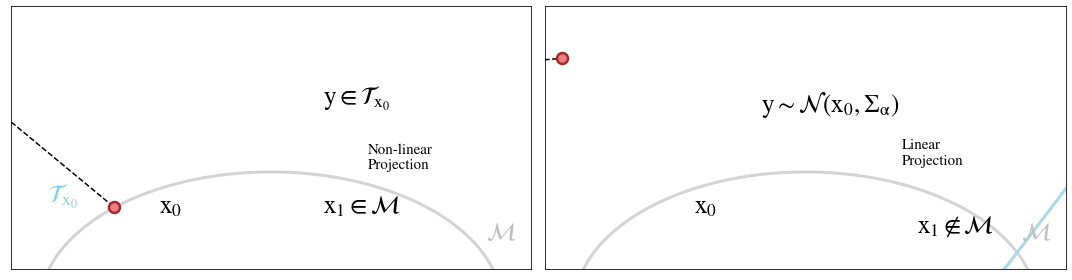

In [34]:
MANIFOLD_LW = 3.0
XMIN = -3.5
XMAX =  3.5
YMIN = 0.5
YMAX = 4
SPOINTS = 120
ZORDER_POINTS = 50
ZORDER_ANNOTATIONS = 20
COLOR_ELLIPSE = 'lightgrey'
XTEXT_X0 = -1.5
YTEXT_X0 = 1.25
XTEXT_X1 = 0.7
YTEXT_X1 = YTEXT_X0
XTEXT_X1HUG = 1.5 #0.7
YTEXT_X1HUG = 1.#YTEXT_X0
XTEXT_Y1 = 0.7
YTEXT_Y1 = 2.7
XTEXT_TANGENT = -3
YTEXT_TANGENT = 1.4
XTEXT_MANIFOLD = 2.9
YTEXT_MANIFOLD = 0.9
ANNOTATION_FONTSIZE=25
TANGENT_COLOR = 'lightblue'
MVN_HUG_CONTOUR_COLOR = TANGENT_COLOR #'lightgray'
rc('font',**{'family':'STIXGeneral'})

xvalues = np.linspace(-3, 1, 100)


fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
### Common plot elements
for i in range(2):
    ax[i].contour(*manifold, levels=[z0], linewidths=MANIFOLD_LW, colors=[COLOR_ELLIPSE], linestyles='solid')
    ax[i].scatter(*x0, s=SPOINTS, zorder=ZORDER_POINTS, color='gray', edgecolor='black', linewidth=2.5)
    #ax[i].arrow(*x0, *(-g0), head_width=0.1, head_length=0.15, facecolor='k', edgecolor='red')
    ax[i].text(XTEXT_MANIFOLD, YTEXT_MANIFOLD, '$\mathregular{\mathcal{M}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS, color='silver')
    ax[i].text(XTEXT_X0, YTEXT_X0, '$\mathregular{x_0}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
    ax[i].set_xlim(XMIN, XMAX)
    ax[i].set_ylim(YMIN, YMAX)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

### Constrained-RWM
ax[0].scatter(*x_mid_rwm, s=SPOINTS, zorder=ZORDER_POINTS, color='dodgerblue', edgecolor='navy', linewidth=2.5)
ax[0].scatter(*x1, s=SPOINTS, zorder=ZORDER_POINTS, color='lightcoral', edgecolor='brown', linewidth=2.5)
ax[0].plot(*vstack((x_mid_rwm, x1)).T, color='k', ls='--')
ax[0].text(XTEXT_X1, YTEXT_X1, '$\mathregular{x_1\in\mathcal{M}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[0].text(XTEXT_Y1, YTEXT_Y1, '$\mathregular{y\in\mathcal{T}_{x_0}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[0].text(1.3, 1.84, 'Non-linear\nProjection', fontsize=15, zorder=ZORDER_ANNOTATIONS)
ax[0].text(XTEXT_TANGENT, YTEXT_TANGENT, '$\mathregular{\mathcal{T}_{x_0}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS, color='skyblue')
ax[0].plot(xvalues, line_perp_v_through_point(g0, x0, xvalues), color=TANGENT_COLOR, lw=MANIFOLD_LW)


### Tangential HUG
ax[1].scatter(*x_mid, s=SPOINTS, zorder=ZORDER_POINTS, color='dodgerblue', edgecolor='navy', linewidth=2.5)
ax[1].scatter(*x1_hug, s=SPOINTS, zorder=ZORDER_POINTS, color='lightcoral', edgecolor='brown', linewidth=2.5)
ax[1].plot(*vstack((x_mid, x1_hug)).T, color='k', ls='--', zorder=19)
ax[1].contour(*contours_mvn_hug, colors=[MVN_HUG_CONTOUR_COLOR], alpha=1.0, linewidths=MANIFOLD_LW)
ax[1].text(XTEXT_X1HUG, YTEXT_X1HUG, '$\mathregular{x_1\,{\\notin}\,\mathcal{M}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[1].text(-0.6, 2.6, '$\mathregular{y\sim\mathcal{N}(x_0, \Sigma_{\\alpha})}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[1].text(1.3, 1.9, 'Linear\nProjection', fontsize=15, zorder=ZORDER_ANNOTATIONS)

### Common settings
plt.tight_layout()
#plt.savefig('figures/constrained_projection_vs_hug_bounce.png', dpi=500)
plt.show()

# C-HMC Mechanism and Reprojection

In [35]:
## reprojection for zappa
Q1 = ellipse.Q(x1)
ty_basis = ellipse.tangent_basis(Q1)
v_prime_sample = (x0 - x1) @ ty_basis
v_prime = v_prime_sample @ ty_basis.T
λ1, _ = project(x1, v_prime, Q1, ellipse.q, 1e-8, 0, 100)
x2 = (x1 + v_prime) + Q1 @ λ1

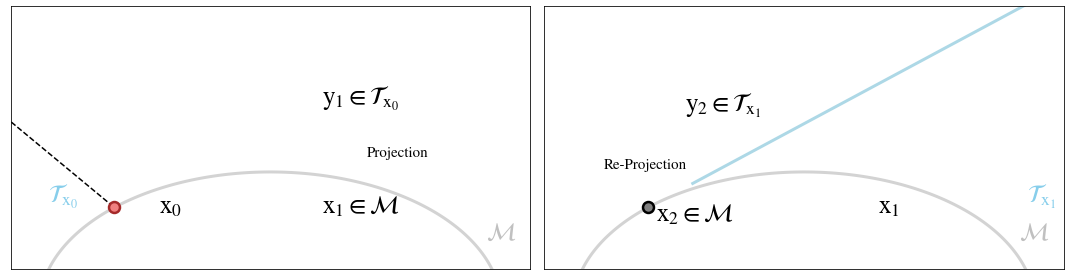

In [37]:
MANIFOLD_LW = 3.0
XMIN = -3.5
XMAX =  3.5
YMIN = 0.5
YMAX = 4
SPOINTS = 120
ZORDER_POINTS = 50
ZORDER_ANNOTATIONS = 20
COLOR_ELLIPSE = 'lightgrey'
XTEXT_X0 = -1.5
YTEXT_X0 = 1.25
XTEXT_X1 = 0.7
YTEXT_X1 = YTEXT_X0
XTEXT_X1HUG = 1.5 #0.7
YTEXT_X1HUG = 1.#YTEXT_X0
XTEXT_Y1 = 0.7
YTEXT_Y1 = 2.7
XTEXT_TANGENT = -3
YTEXT_TANGENT = 1.4
XTEXT_MANIFOLD = 2.9
YTEXT_MANIFOLD = 0.9
ANNOTATION_FONTSIZE=25
TANGENT_COLOR = 'lightblue'
MVN_HUG_CONTOUR_COLOR = TANGENT_COLOR #'lightgray'
rc('font',**{'family':'STIXGeneral'})

xvalues = np.linspace(-3, 1, 100)
xvalues_backward = np.linspace(-1.5, 3, 100)
g1 = grad_f(x1) / norm(grad_f(x1))


fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
### Common plot elements
for i in range(2):
    ax[i].contour(*manifold, levels=[z0], linewidths=MANIFOLD_LW, colors=[COLOR_ELLIPSE], linestyles='solid')
    #ax[i].arrow(*x0, *(-g0), head_width=0.1, head_length=0.15, facecolor='k', edgecolor='red')
    ax[i].text(XTEXT_MANIFOLD, YTEXT_MANIFOLD, '$\mathregular{\mathcal{M}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS, color='silver')
    ax[i].set_xlim(XMIN, XMAX)
    ax[i].set_ylim(YMIN, YMAX)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

### FORWARD
ax[0].scatter(*x_mid_rwm, s=SPOINTS, zorder=ZORDER_POINTS, color='dodgerblue', edgecolor='navy', linewidth=2.5)
ax[0].scatter(*x1, s=SPOINTS, zorder=ZORDER_POINTS, color='lightcoral', edgecolor='brown', linewidth=2.5)
ax[0].plot(*vstack((x_mid_rwm, x1)).T, color='k', ls='--')
ax[0].text(XTEXT_X1, YTEXT_X1, '$\mathregular{x_1\in\mathcal{M}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[0].text(XTEXT_Y1, YTEXT_Y1, '$\mathregular{y_1\in\mathcal{T}_{x_0}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[0].text(XTEXT_TANGENT, YTEXT_TANGENT, '$\mathregular{\mathcal{T}_{x_0}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS, color='skyblue')
ax[0].plot(xvalues, line_perp_v_through_point(g0, x0, xvalues), color=TANGENT_COLOR, lw=MANIFOLD_LW)
ax[0].scatter(*x0, s=SPOINTS, zorder=ZORDER_POINTS, color='gray', edgecolor='black', linewidth=2.5)
ax[0].text(XTEXT_X0, YTEXT_X0, '$\mathregular{x_0}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[0].text(1.3, 2., 'Projection', fontsize=15, zorder=ZORDER_ANNOTATIONS)


### BACKWARD
ax[1].scatter(*x2, s=SPOINTS, zorder=ZORDER_POINTS, color='lightcoral', edgecolor='brown', linewidth=2.5)
ax[1].scatter(*(x1+v_prime), s=SPOINTS, zorder=ZORDER_POINTS, color='dodgerblue', edgecolor='navy', linewidth=2.5)
ax[1].scatter(*x1, s=SPOINTS, zorder=ZORDER_POINTS, color='gray', edgecolor='black', linewidth=2.5)
ax[1].plot(*vstack(((x1+v_prime), x2)).T, color='k', ls='--')
ax[1].text(XTEXT_X1+0.3, YTEXT_X1, '$\mathregular{x_1}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[1].text(XTEXT_Y1-2.3, YTEXT_Y1-0.1, '$\mathregular{y_2\in\mathcal{T}_{x_1}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[1].text(-XTEXT_TANGENT, YTEXT_TANGENT, '$\mathregular{\mathcal{T}_{x_1}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS, color='skyblue')
ax[1].plot(xvalues_backward, line_perp_v_through_point(g1, x1, xvalues_backward), color=TANGENT_COLOR, lw=MANIFOLD_LW)
ax[1].text(XTEXT_X0-0.5, YTEXT_X0-0.1, '$\mathregular{x_2\in\mathcal{M}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[1].text(-2.7, 1.85, 'Re-Projection', fontsize=15, zorder=ZORDER_ANNOTATIONS)


### Common settings
plt.tight_layout()
#plt.savefig('figures/chmc_projection_and_reprojection.png', dpi=500)
plt.show()

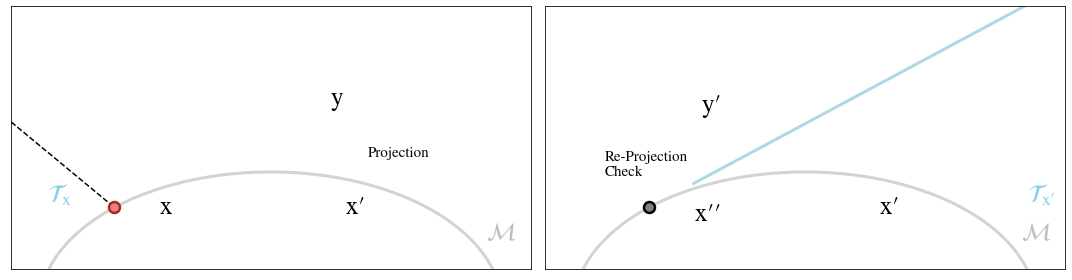

In [38]:
MANIFOLD_LW = 3.0
XMIN = -3.5
XMAX =  3.5
YMIN = 0.5
YMAX = 4
SPOINTS = 120
ZORDER_POINTS = 50
ZORDER_ANNOTATIONS = 20
COLOR_ELLIPSE = 'lightgrey'
XTEXT_X0 = -1.5
YTEXT_X0 = 1.25
XTEXT_X1 = 0.7
YTEXT_X1 = YTEXT_X0
XTEXT_X1HUG = 1.5 #0.7
YTEXT_X1HUG = 1.#YTEXT_X0
XTEXT_Y1 = 0.7
YTEXT_Y1 = 2.7
XTEXT_TANGENT = -3
YTEXT_TANGENT = 1.4
XTEXT_MANIFOLD = 2.9
YTEXT_MANIFOLD = 0.9
ANNOTATION_FONTSIZE=25
TANGENT_COLOR = 'lightblue'
MVN_HUG_CONTOUR_COLOR = TANGENT_COLOR #'lightgray'
rc('font',**{'family':'STIXGeneral'})

xvalues = np.linspace(-3, 1, 100)
xvalues_backward = np.linspace(-1.5, 3, 100)
g1 = grad_f(x1) / norm(grad_f(x1))


fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
### Common plot elements
for i in range(2):
    ax[i].contour(*manifold, levels=[z0], linewidths=MANIFOLD_LW, colors=[COLOR_ELLIPSE], linestyles='solid')
    #ax[i].arrow(*x0, *(-g0), head_width=0.1, head_length=0.15, facecolor='k', edgecolor='red')
    ax[i].text(XTEXT_MANIFOLD, YTEXT_MANIFOLD, '$\mathregular{\mathcal{M}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS, color='silver')
    ax[i].set_xlim(XMIN, XMAX)
    ax[i].set_ylim(YMIN, YMAX)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

### FORWARD
ax[0].scatter(*x_mid_rwm, s=SPOINTS, zorder=ZORDER_POINTS, color='dodgerblue', edgecolor='navy', linewidth=2.5)
ax[0].scatter(*x1, s=SPOINTS, zorder=ZORDER_POINTS, color='lightcoral', edgecolor='brown', linewidth=2.5)
ax[0].plot(*vstack((x_mid_rwm, x1)).T, color='k', ls='--')
ax[0].text(XTEXT_X1+0.3, YTEXT_X1, '$\mathregular{x\prime}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[0].text(XTEXT_Y1+0.1, YTEXT_Y1, '$\mathregular{y}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[0].text(XTEXT_TANGENT, YTEXT_TANGENT, '$\mathregular{\mathcal{T}_{x}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS, color='skyblue')
ax[0].plot(xvalues, line_perp_v_through_point(g0, x0, xvalues), color=TANGENT_COLOR, lw=MANIFOLD_LW)
ax[0].scatter(*x0, s=SPOINTS, zorder=ZORDER_POINTS, color='gray', edgecolor='black', linewidth=2.5)
ax[0].text(XTEXT_X0, YTEXT_X0, '$\mathregular{x}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[0].text(1.3, 2., 'Projection', fontsize=15, zorder=ZORDER_ANNOTATIONS)


### BACKWARD
ax[1].scatter(*x2, s=SPOINTS, zorder=ZORDER_POINTS, color='lightcoral', edgecolor='brown', linewidth=2.5)
ax[1].scatter(*(x1+v_prime), s=SPOINTS, zorder=ZORDER_POINTS, color='dodgerblue', edgecolor='navy', linewidth=2.5)
ax[1].scatter(*x1, s=SPOINTS, zorder=ZORDER_POINTS, color='gray', edgecolor='black', linewidth=2.5)
ax[1].plot(*vstack(((x1+v_prime), x2)).T, color='k', ls='--')
ax[1].text(XTEXT_X1+0.3, YTEXT_X1, '$\mathregular{x\prime}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[1].text(XTEXT_Y1-2.1, YTEXT_Y1-0.1, '$\mathregular{y\prime}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[1].text(-XTEXT_TANGENT, YTEXT_TANGENT, '$\mathregular{\mathcal{T}_{x\prime}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS, color='skyblue')
ax[1].plot(xvalues_backward, line_perp_v_through_point(g1, x1, xvalues_backward), color=TANGENT_COLOR, lw=MANIFOLD_LW)
ax[1].text(XTEXT_X0-0.0, YTEXT_X0-0.1, '$\mathregular{x\prime\prime}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[1].text(-2.7, 1.75, 'Re-Projection\nCheck', fontsize=15, zorder=ZORDER_ANNOTATIONS)


### Common settings
plt.tight_layout()
#plt.savefig('figures/chmc_projection_and_reprojection_new.png', dpi=500)
plt.show()

# Double Projection

In [941]:
μ2 = zeros(2)
Σ2 = array([[8.0, 0.0], [0.0, 0.9]])
π2 = MVN(μ2, Σ2)
f2 = π2.logpdf
grad_f2 = lambda x: - solve(Σ2, x - μ2)
#z0 = -2.9513586307684885
z02 = -5.0
ellipse2 = GeneralizedEllipse(μ2, Σ2, exp(z02))
manifold2 = prep_contour([-8, 8], [-8, 8], 0.01, f2)

In [973]:
# # Points and Velocities for Zappa RWM
init_point2 = array([5.1, 1])#array([-1.25, 0.75])
x0_2 = find_point_closest_to(init_point2, f=f2, z0=z02)
v0_2 = sample_along_tangent(x0_2, v=1.5, σ=0.85, seed=1115, use_abs=False, ellipse=ellipse2)
λ2  = project(x0_2, v0_2, ellipse2.Q(x0_2), ellipse2.q)[0]
x1_2 = (x0_2 + v0_2) + ellipse2.Q(x0_2) @ λ2
λ2_second  = project(x0_2, v0_2, ellipse2.Q(x0_2), ellipse2.q, a_guess=-4)[0]
x1_2_second = (x0_2 + v0_2) + ellipse2.Q(x0_2) @ λ2_second
# # Point for HUG
# x_mid = x0 + v0
# g_mid = grad_f(x_mid) / norm(grad_f(x_mid))
# v1 = v0 - 2*g_mid * (g_mid @ v0)
# x1_hug = x_mid + v1

# # Point for HUG but using the initial Jacobian
# x_mid = x0 + v0
g0_2 = grad_f2(x0_2) / norm(grad_f2(x0_2))
# v1_new = v0 - 2*g0 * (g0 @ v0)
# x1_hug_new = x_mid + v1_new

In [974]:
# see if from x1_2_second we are able to recover x0
Q1_2_second = ellipse2.Q(x1_2_second)
ty_basis_2_second = ellipse2.tangent_basis(Q1_2_second)
v_prime_sample_2_second = (x0_2 - x1_2_second) @ ty_basis_2_second
v_prime_2_second = v_prime_sample_2_second @ ty_basis_2_second.T
λ1_2_second, _ = project(x1_2_second, v_prime_2_second, Q1_2_second, ellipse2.q, 1e-8, 0, 100)
x2_2_second = (x1_2_second + v_prime_2_second) + Q1_2_second @ λ1_2_second

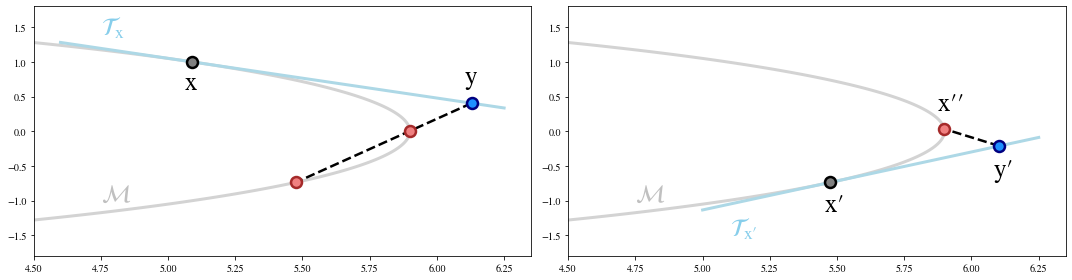

In [1036]:
MANIFOLD_LW = 3.0
XMIN = 4.5
XMAX =  6.35
YMIN = -1.8
YMAX = 1.8
SPOINTS = 120
ZORDER_POINTS = 50
ZORDER_ANNOTATIONS = 20
COLOR_ELLIPSE = 'lightgrey'
XTEXT_X0 = 5.06
YTEXT_X0 = 0.6
XTEXT_X1 = 0.7
YTEXT_X1 = YTEXT_X0
XTEXT_X1HUG = 1.5 #0.7
YTEXT_X1HUG = 1.#YTEXT_X0
XTEXT_Y1 = 6.1
YTEXT_Y1 = 0.7
XTEXT_TANGENT = 4.75
YTEXT_TANGENT = 1.4
XTEXT_MANIFOLD = 4.75
YTEXT_MANIFOLD = -1
ANNOTATION_FONTSIZE=25
TANGENT_COLOR = 'lightblue'
MVN_HUG_CONTOUR_COLOR = TANGENT_COLOR #'lightgray'
rc('font',**{'family':'STIXGeneral'})

xvalues_2 = np.linspace(4.6, 6.25, 100)
# xvalues_backward = np.linspace(-1.5, 3, 100)
# g1 = grad_f(x1) / norm(grad_f(x1))
xvalues_2_second = np.linspace(5, 6.25, 100)


fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
### Common plot elements
for i in range(2):
    ax[i].contour(*manifold2, levels=[z02], linewidths=MANIFOLD_LW, colors=[COLOR_ELLIPSE], linestyles='solid')
#     ax[i].arrow(*x0_2, *(-g0_2), head_width=0.1, head_length=0.15, facecolor='k', edgecolor='red')
    ax[i].text(XTEXT_MANIFOLD, YTEXT_MANIFOLD, '$\mathregular{\mathcal{M}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS, color='silver')
    ax[i].set_xlim(XMIN, XMAX)
    ax[i].set_ylim(YMIN, YMAX)
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])

### FORWARD
# ax[0].scatter(*x_mid_rwm, s=SPOINTS, zorder=ZORDER_POINTS, color='dodgerblue', edgecolor='navy', linewidth=2.5)
# ax[0].scatter(*x1, s=SPOINTS, zorder=ZORDER_POINTS, color='lightcoral', edgecolor='brown', linewidth=2.5)
# ax[0].plot(*vstack((x_mid_rwm, x1)).T, color='k', ls='--')
# ax[0].text(XTEXT_X1+0.3, YTEXT_X1, '$\mathregular{x\prime}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[0].text(XTEXT_Y1, YTEXT_Y1, '$\mathregular{y}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[0].text(XTEXT_TANGENT, YTEXT_TANGENT, '$\mathregular{\mathcal{T}_{x}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS, color='skyblue')
ax[0].plot(xvalues_2, line_perp_v_through_point(g0_2, x0_2, xvalues_2), color=TANGENT_COLOR, lw=MANIFOLD_LW)
ax[0].scatter(*x0_2, s=SPOINTS, zorder=ZORDER_POINTS, color='gray', edgecolor='black', linewidth=2.5)
ax[0].text(XTEXT_X0, YTEXT_X0, '$\mathregular{x}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
# ax[0].text(1.3, 2., 'Projection', fontsize=15, zorder=ZORDER_ANNOTATIONS)
ax[0].scatter(*(x0_2+v0_2), s=SPOINTS, zorder=ZORDER_POINTS, color='dodgerblue', edgecolor='navy', linewidth=2.5)
ax[0].scatter(*x1_2, s=SPOINTS, zorder=ZORDER_POINTS, color='lightcoral', edgecolor='brown', linewidth=2.5)
ax[0].scatter(*x1_2_second, s=SPOINTS, zorder=ZORDER_POINTS, color='lightcoral', edgecolor='brown', linewidth=2.5)
ax[0].plot(*np.vstack((x0_2 + v0_2, x1_2_second)).T, linestyle='--', color='k', linewidth=2.5)
#ax[0].text(5.87, -0.35, '$\mathregular{x_1\prime}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)

### BACKWARD
# ax[1].scatter(*x2, s=SPOINTS, zorder=ZORDER_POINTS, color='lightcoral', edgecolor='brown', linewidth=2.5)
# ax[1].scatter(*(x1+v_prime), s=SPOINTS, zorder=ZORDER_POINTS, color='dodgerblue', edgecolor='navy', linewidth=2.5)
# ax[1].scatter(*x1, s=SPOINTS, zorder=ZORDER_POINTS, color='gray', edgecolor='black', linewidth=2.5)
# ax[1].plot(*vstack(((x1+v_prime), x2)).T, color='k', ls='--')
# ax[1].text(XTEXT_X1+0.3, YTEXT_X1, '$\mathregular{x\prime}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
# ax[1].text(XTEXT_Y1-2.1, YTEXT_Y1-0.1, '$\mathregular{y\prime}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[1].text(5.1, -1.5, '$\mathregular{\mathcal{T}_{x\prime}}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS, color='skyblue')
# ax[1].plot(xvalues_backward, line_perp_v_through_point(g1, x1, xvalues_backward), color=TANGENT_COLOR, lw=MANIFOLD_LW)
# ax[1].text(XTEXT_X0-0.0, YTEXT_X0-0.1, '$\mathregular{x\prime\prime}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
# ax[1].text(-2.7, 1.75, 'Re-Projection\nCheck', fontsize=15, zorder=ZORDER_ANNOTATIONS)
ax[1].scatter(*x1_2_second, s=SPOINTS, zorder=ZORDER_POINTS, color='gray', edgecolor='black', linewidth=2.5)
ax[1].plot(xvalues_2_second, line_perp_v_through_point(Q1_2_second.flatten(), x1_2_second, xvalues_2_second), color=TANGENT_COLOR, lw=MANIFOLD_LW)
ax[1].scatter(*(x1_2_second+v_prime_2_second), s=SPOINTS, zorder=ZORDER_POINTS, color='dodgerblue', edgecolor='navy', linewidth=2.5)
ax[1].scatter(*x2_2_second, s=SPOINTS, zorder=ZORDER_POINTS, color='lightcoral', edgecolor='brown', linewidth=2.5)
ax[1].plot(*np.vstack((x1_2_second+v_prime_2_second, x2_2_second)).T, linestyle='--', color='k', linewidth=2.5)
ax[1].text(5.45, -1.15, '$\mathregular{x\prime}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[1].text(6.08, -0.65, '$\mathregular{y\prime}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)
ax[1].text(5.87, 0.3, '$\mathregular{x\prime\prime}$', fontsize=ANNOTATION_FONTSIZE, zorder=ZORDER_ANNOTATIONS)


### Common settings
plt.tight_layout()
plt.savefig('figures/chmc_reprojection_fail.png', dpi=500)
plt.show()

In [905]:
x1_2_second+v_prime_2_second

array([ 6.09156372, -0.38851803])

In [906]:
v_prime_2_second

array([-0.0308965 , -0.03328105])

In [1048]:
Qred = qr(Q1, mode='economic')[0]

In [1052]:
ProjMat = Qred @ Qred.T

In [1058]:
Qred

array([[-0.20675685],
       [-0.97839236]])

In [1061]:
A = randn(5, 4)

In [1063]:
QA = qr(A, mode='economic')[0]

In [1065]:
QA @ QA.T

array([[ 0.72649909,  0.3054494 ,  0.06941854,  0.13658414, -0.28622485],
       [ 0.3054494 ,  0.65887011, -0.07752753, -0.15253896,  0.31965966],
       [ 0.06941854, -0.07752753,  0.98238056, -0.03466706,  0.07264806],
       [ 0.13658414, -0.15253896, -0.03466706,  0.93179098,  0.14293838],
       [-0.28622485,  0.31965966,  0.07264806,  0.14293838,  0.70045926]])

In [1068]:
(QA.T @ QA).round()

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1., -0., -0.],
       [ 0., -0.,  1., -0.],
       [ 0., -0., -0.,  1.]])

NameError: name 'vm' is not defined